In [463]:
 #* for data manipulation 
import pandas as pd 
import numpy as np 

from disk_analysis_tools import tiling_disk_plots as tdp
from disk_analysis_tools import tiling_disk_utils as tdu

#* sometimes needed for creating bins for histograms 
from astropy.stats import knuth_bin_width

#* for plotting: 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
# sns.set_theme(style="ticks")
sns.set_context("talk")
from astropy.stats import bootstrap
from scipy.special import erfinv


study of glue trace widths on paper

# blue tip paper

In [464]:
from pathlib import Path
measurement_folder  = Path.cwd().parent / 'excel_data'

In [465]:
blue_data = pd.read_excel(measurement_folder/'vel_vs_width_messung.xlsx', sheet_name='Blau')
blue_data.rename(columns={'value [µm]': 'width'}, inplace=True)

In [466]:
blue_data.head(3)

,tip,horzizontal_wait,velocity,arm,point,width,value_nr
0,Blau,0.1,3.3,1,1,989.7408,1
1,Blau,0.1,3.3,1,1,1009.9623,2
2,Blau,0.1,3.3,1,1,1002.7434,3


In [467]:
def plot_point_hist_per_vel(glueline_data, velocity=5.5): 
    vel_data = glueline_data.query(f'velocity=={velocity}')
    point_list = glueline_data['point'].unique()
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    fig.suptitle(f'{v} mm/s')
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    for color, point in zip(colors, point_list): 
        dt = vel_data.query(f'point=={point}')
        sns.histplot(data=dt, x='width',ax=ax, color=color, element='step', alpha=0.4, 
                    label=f'Point {point}')
        ax.set_xlabel('width [µm]')
    ax.grid(c="grey", ls="-", lw=1, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    return fig, ax

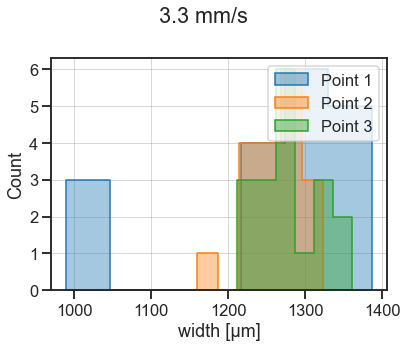

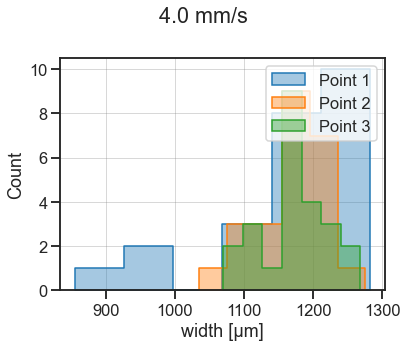

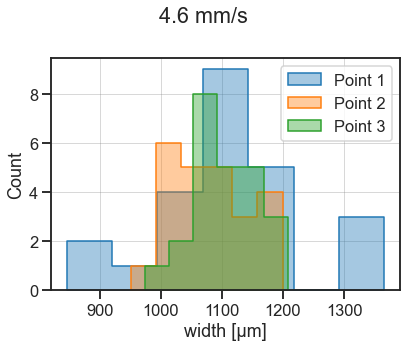

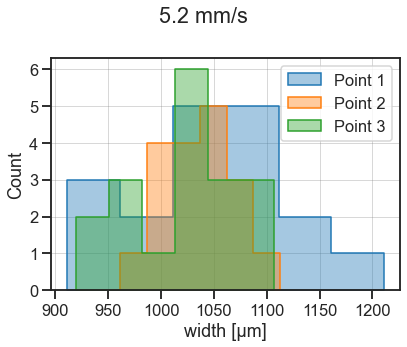

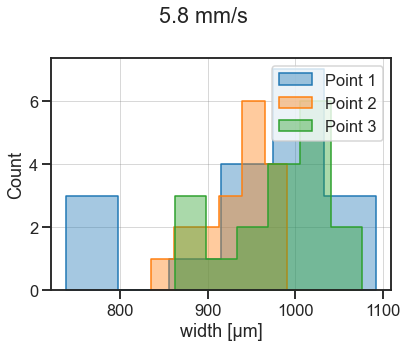

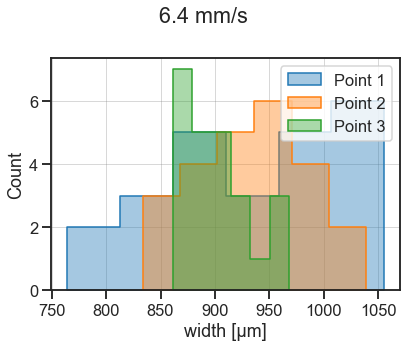

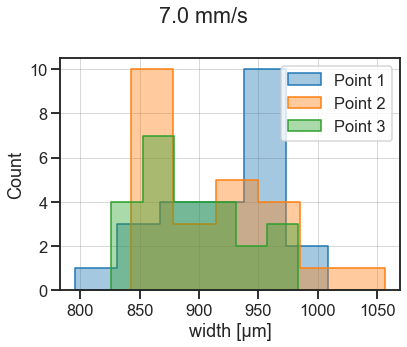

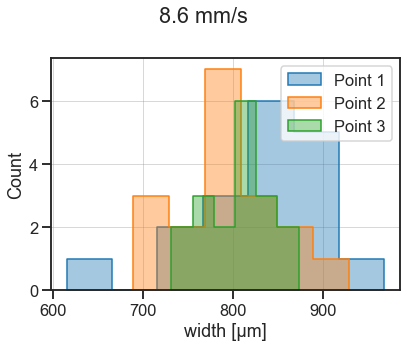

In [468]:
vel_list = blue_data['velocity'].unique()
for v in vel_list: 
    plot_point_hist_per_vel(blue_data, velocity=v)

In [469]:
vel_list = blue_data['velocity'].unique()

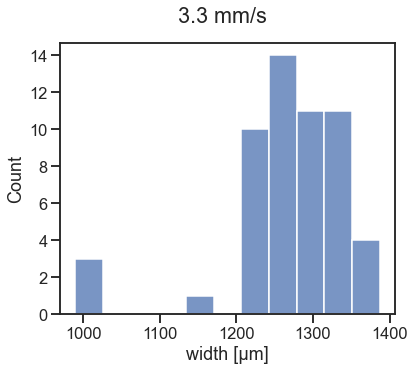

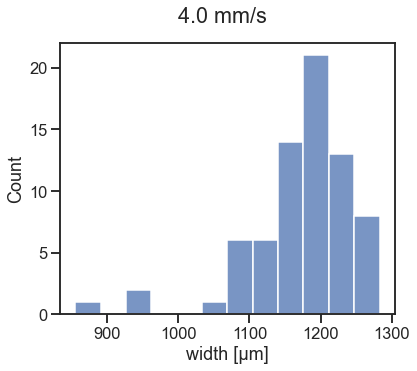

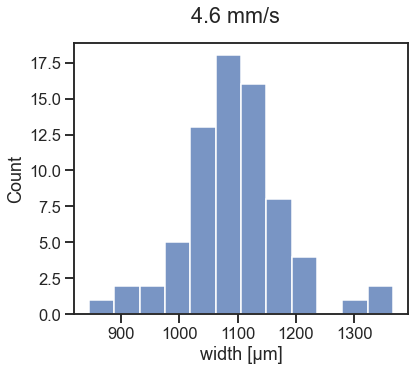

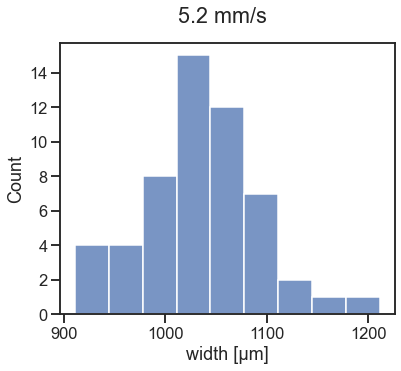

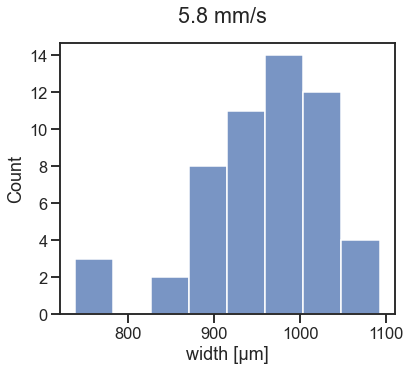

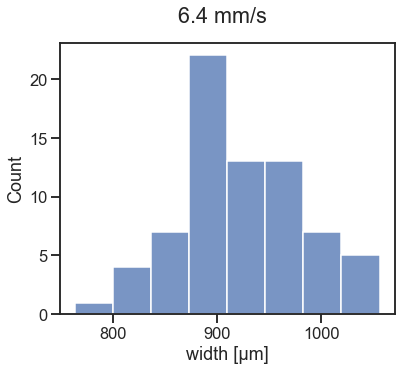

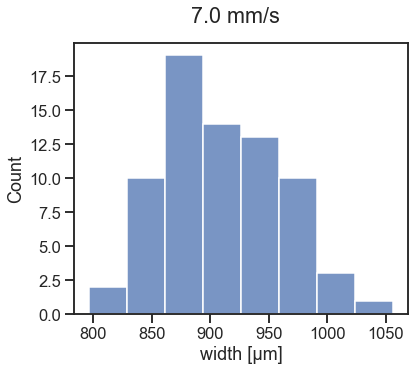

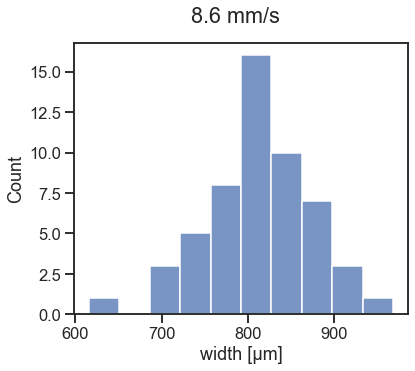

In [470]:
for v in vel_list:
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    fig.suptitle(f'{v} mm/s')
    sns.histplot(data=blue_data.query(f'velocity=={v}'), x='width', ax=ax)
    ax.set_xlabel('width [µm]')
    # ax.set_title(f'{v} mm/s')

In [471]:
# blue_data = blue_data.query('point == 1')
blue_stripped = blue_data.drop(['arm', 'point', 'value_nr'], axis=1)

In [472]:
group_test = blue_stripped.groupby(['velocity']).agg(['mean', 'median', 'std', 'count', lambda x: x.std()/np.sqrt(x.count()), 'max'])
group_test.reset_index(inplace=True)
group_test.columns = ['_'.join(col).rstrip('_') for col in group_test.columns.values]

C:\Users\Domin\AppData\Local\Temp\ipykernel_20204\1695154126.py:1: FutureWarning: ['tip'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  group_test = blue_stripped.groupby(['velocity']).agg(['mean', 'median', 'std', 'count', lambda x: x.std()/np.sqrt(x.count()), 'max'])


In [473]:
group_test.drop(['horzizontal_wait_<lambda_0>', 'horzizontal_wait_count', 'horzizontal_wait_std', 'horzizontal_wait_median', 'horzizontal_wait_mean'], axis=1, inplace=True)
group_test.rename(columns={'width_<lambda_0>': 'width_err', 'horzizontal_wait_max': 'h_w'}, inplace=True)

In [474]:
group_test

,velocity,h_w,width_mean,width_median,width_std,width_count,width_err,width_max
0,3.3,0.1,1267.584972,1278.13265,80.203682,54,10.914339,1386.9121
1,4.0,0.1,1172.562531,1186.50000,77.208601,72,9.099121,1282.7216
2,4.6,0.1,1095.888724,1087.75630,87.074606,72,10.261841,1366.2290
3,5.2,0.1,1035.078252,1033.21490,59.823090,54,8.140891,1211.2906
4,5.8,0.1,958.217883,964.53990,77.993105,54,10.613517,1092.2270
5,6.4,0.1,923.240989,914.90035,61.508162,72,7.248806,1055.6843
6,7.0,0.1,909.888772,908.36300,50.959970,72,6.005690,1056.2837
7,8.6,0.1,810.359194,812.11695,62.906760,54,8.560526,968.0279


C:\Users\Domin\AppData\Local\Temp\ipykernel_20204\2743250566.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x=xs,


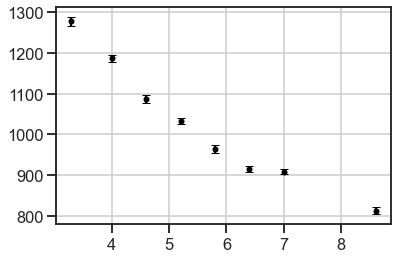

In [475]:
# group_test = group_test.query('h_w!= 0.1')
xs = group_test['velocity']
ys = group_test['width_median']
ye = group_test['width_err']
fig, ax = plt.subplots(1,1)
ax.errorbar(x=xs,
            y=ys,
            yerr=ye,
            capsize=4, marker='o',
            markersize=5,
            fmt='o', 
            color='black')
plt.grid(visible=True, axis='both')
# ax.set_xlim(0,13)
# ax.set_ylim(0,1450)

In [476]:
from iminuit import cost, Minuit
def model(x, a, b, c):
    return a * np.exp(b * x) + c

c = cost.LeastSquares(xs, ys, ye, model)

m = Minuit(c, a=0, b=0, c=0)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.44 (chi2/ndof = 3.3)    │              Nfcn = 200              │
│ EDM = 1.3e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  1.57e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ b    │  -0.300   │   0.031   │            │            │         │         │       │
│ 2 │ c    │    700    │    31     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 1.05e+04    -2.99 2.67e+03 │
│ b │    -2.99 0.000967   -0.937 │
│ c │ 2.67e+03   -0.937      959 │
└───┴────────────────────────────┘

In [477]:
m.values

<ValueView a=1572.4914237047901 b=-0.2999872728844597 c=700.0929414221143>

In [478]:
a = 1572.4914237047901
b = -0.2999872728844597
c = 700.0929414221143

In [479]:
model(4.2, a,b,c)

1146.1603087889453

In [480]:
import numpy as np
def x(y): 
    return 1/b * np.log((y-c)/a)

In [481]:
print(x(1150))

4.171428666504429


In [482]:
print(*m.values)

1572.4914237047901 -0.2999872728844597 700.0929414221143


In [483]:
chi_sq = m.fval / m.ndof

In [484]:
#  1017.8506413346119, -0.0691873808176167, 493.36555160634487  die schnellen chi2/ndof = 8.5)

In [485]:
def plot_width_vs_w_errorbar(data, h_w, color, size=3**2 ,ax=None):
    xs = data['velocity']
    ys = data['width_median']
    ye = data['width_err']
    if ax !=None:
        ax.errorbar(xs, ys, ye, fmt='o',
                     label=f"horizontal wait: {h_w}",
                     markersize=size, capsize=4, color=color, ecolor=color)
    else: 
        plt.errorbar(xs, ys, ye, fmt='o',
                     label=f"horizontal wait: {h_w}",
                     markersize=size, capsize=4, color=color, ecolor=color)

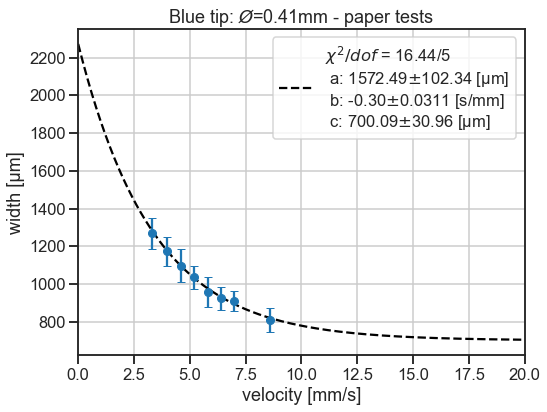

In [486]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,6))
plt.errorbar(group_test['velocity'], group_test['width_mean'], group_test['width_std'], fmt='o',
                     
                     markersize=8, capsize=4, color='tab:blue', ecolor='tab:blue')
# for h_w, c in zip(group_test['h_w'].unique(), ['tab:blue', 'tab:orange', 'tab:green']):
#     data = group_test.query(f'h_w == {h_w}')
#     plot_width_vs_w_errorbar(data, h_w, c, ax=ax)
model_xs = np.arange(0,50,0.1)
label = f"$\chi^2/dof$ = {m.fval:.2f}/{m.ndof:.0f} \n \
a: {a:.2f}$\pm${m.errors['a']:.2f} [µm]\n \
b: {b:.2f}$\pm${m.errors['b']:.4f} [s/mm] \n \
c: {c:.2f}$\pm${m.errors['c']:.2f} [µm]"
ax.plot(model_xs, model(model_xs, *m.values), label=label, c='black', ls='--', )
ax.set_xlabel('velocity [mm/s]')
ax.set_ylabel('width [µm]')
ax.set_title('Blue tip: $\O$=0.41mm - paper tests')
ax.grid(visible=True, axis='both')
ax.set_xlim(0, 20)
ax.legend();

In [487]:
# sns.set_context('paper')
# for h_w, c in zip(group_test['h_w'].unique(), ['tab:blue', 'tab:orange', 'tab:green']):
#     data = group_test.query(f'h_w == {h_w}')
#     plot_width_vs_w_errorbar(data, h_w, c)

# model_xs = np.arange(0,50,0.1)
# label = f"$\chi^2/dof$ = {m.fval:.2f}/{m.ndof:.0f} \n \
# a: {a:.2f}$\pm${m.errors['a']:.2f} [µm]\n \
# b: {b:.2f}$\pm${m.errors['b']:.4f} [s/mm] \n \
# c: {c:.2f}$\pm${m.errors['c']:.2f} [µm]"
# plt.plot(model_xs, model(model_xs, *m.values), label=label, c='black', ls='--', )
# plt.grid(visible=True, axis='both')
# plt.legend();

In [488]:
def plot_v_vs_std_errorbar(data, h_w, color):
    xs = data['velocity']
    ys = data['width_std']
    # ye = data['width_err'] #? Error is missing :/

    # plt.errorbar(xs, ys, ye, fmt='ok', label=f"horizontal wait: {h_w}", markersize=6, capsize=4, color=color, ecolor=color)
    plt.errorbar(xs, ys, fmt='o', label=f"horizontal wait: {h_w}", markersize=6, capsize=4, color=color,)

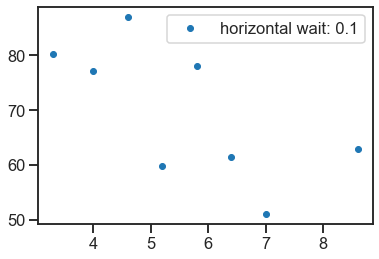

In [489]:
for h_w, c in zip(group_test['h_w'].unique(), ['tab:blue', 'tab:orange', 'tab:green']):
    data = group_test.query(f'h_w == {h_w}')
    plot_v_vs_std_errorbar(data, h_w, c)
    plt.legend()

In [490]:
def Bootstrap(data, statistic, alpha=0.95, n_samples=10000):
    if not (0 < alpha < 1):
        raise ValueError("confidence level must be in (0, 1)")

    n = n_samples
    if n <= 0:
        raise ValueError("data must contain at least one measurement.")


        
    boot_stat = bootstrap(data, n_samples, bootfunc=statistic)
    stat_data = statistic(data)
    mean_stat = np.mean(boot_stat)
    est_stat = 2*stat_data - mean_stat
    std_err = np.std(boot_stat)
    z_score = np.sqrt(2.0)*erfinv(alpha)
    conf_interval = est_stat + z_score*np.array((-std_err, std_err))
    
    
    return est_stat, std_err, conf_interval

def std_err(data): 
    """Wrapper for bootstrap error on the std statistic"""
    stat, err, conf = Bootstrap(data, np.std,)
    return err

## pink tip paper

In [491]:
rosa_data_1 = pd.read_excel(measurement_folder/'vel_vs_width_messung.xlsx', sheet_name='Rosa')
rosa_data_2 = pd.read_excel(measurement_folder/'vel_vs_width_messung.xlsx', sheet_name='Rosa2')
rosa_data = pd.concat([rosa_data_1, rosa_data_2])
rosa_data.rename(columns={'value [µm]': 'width'}, inplace=True)

In [492]:
vel_list = rosa_data['velocity'].unique()
rosa_stripped = rosa_data.drop(['arm', 'point', 'value_nr'], axis=1)
group_test = rosa_stripped.groupby(['velocity']).agg(['mean', 'median', 'std', 'count', lambda x: x.std()/np.sqrt(x.count()), 'max'])
group_test.reset_index(inplace=True)
group_test.columns = ['_'.join(col).rstrip('_') for col in group_test.columns.values]

C:\Users\Domin\AppData\Local\Temp\ipykernel_20204\2164583557.py:3: FutureWarning: ['tip'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  group_test = rosa_stripped.groupby(['velocity']).agg(['mean', 'median', 'std', 'count', lambda x: x.std()/np.sqrt(x.count()), 'max'])


In [493]:
group_test.drop(['horzizontal_wait_<lambda_0>', 'horzizontal_wait_count', 'horzizontal_wait_std', 'horzizontal_wait_median', 'horzizontal_wait_mean'], axis=1, inplace=True)
group_test.rename(columns={'width_<lambda_0>': 'width_err', 'horzizontal_wait_max': 'h_w'}, inplace=True)

C:\Users\Domin\AppData\Local\Temp\ipykernel_20204\2743250566.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x=xs,


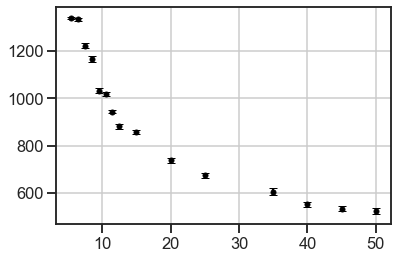

In [494]:
# group_test = group_test.query('h_w!= 0.1')
xs = group_test['velocity']
ys = group_test['width_median']
ye = group_test['width_err']
fig, ax = plt.subplots(1,1)
ax.errorbar(x=xs,
            y=ys,
            yerr=ye,
            capsize=4, marker='o',
            markersize=5,
            fmt='o', 
            color='black')
plt.grid(visible=True, axis='both')
# ax.set_xlim(0,13)
# ax.set_ylim(0,1450)

In [495]:
from iminuit import cost, Minuit
def model(x, a, b, c):
    return a * np.exp(b * x) + c

c = cost.LeastSquares(xs, ys, ye, model)

m = Minuit(c, a=0, b=0, c=0)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 152.7 (chi2/ndof = 12.7)   │              Nfcn = 166              │
│ EDM = 1.18e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  1.451e3  │  0.018e3  │            │            │         │         │       │
│ 1 │ b    │  -0.1056  │  0.0025   │            │            │         │         │       │
│ 2 │ c    │    541    │     7     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │      319  -0.0331     26.7 │
│ b │  -0.0331 6.05e-06  -0.0131 │
│ c │     26.7  -0.0131     48.6 │
└───┴────────────────────────────┘

In [496]:
a,b,c = m.values

In [497]:
m.errors['b']

0.002459482374919652

In [498]:
b

-0.10561467545838227

In [499]:
import numpy as np
def x(y): 
    return 1/b * np.log((y-c)/a)

In [500]:
chi_sq = m.fval / m.ndof

In [501]:
group_test

,velocity,h_w,width_mean,width_median,width_std,width_count,width_err,width_max
0,5.5,0.10,1331.967637,1340.08545,33.524131,54,4.562056,1385.8067
1,6.5,0.10,1319.206644,1333.07575,70.251189,72,8.279182,1412.2232
2,7.5,0.10,1247.393929,1222.78650,100.699099,72,11.867503,1557.9760
3,8.5,0.10,1182.299857,1166.32490,106.907779,54,14.548306,1429.8329
4,9.5,0.10,1043.660104,1032.21865,79.058534,54,10.758504,1170.3064
5,10.5,0.10,1034.615694,1019.34120,72.875310,72,8.588438,1201.2051
6,11.5,0.10,945.773774,944.38185,69.062003,72,8.139035,1131.1903
7,12.5,0.10,893.727544,882.07360,71.853759,54,9.778058,1052.8293
8,15.0,0.05,870.506079,857.94845,74.412550,72,8.769603,1024.5936
9,20.0,0.05,758.895868,738.02335,80.651561,72,9.504878,989.7858


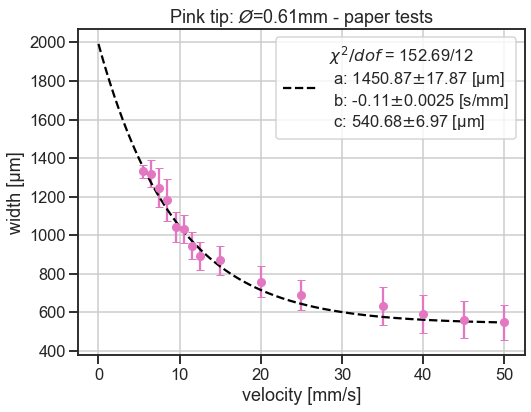

In [502]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,6))
plt.errorbar(group_test['velocity'], group_test['width_mean'], group_test['width_std'], fmt='o',
                     
                     markersize=8, capsize=4, color='tab:pink', ecolor='tab:pink')
# for h_w, c in zip(group_test['h_w'].unique(), ['tab:blue', 'tab:orange', 'tab:green']):
#     data = group_test.query(f'h_w == {h_w}')
#     plot_width_vs_w_errorbar(data, h_w, c, ax=ax)
model_xs = np.arange(0,50,0.1)
label = f"$\chi^2/dof$ = {m.fval:.2f}/{m.ndof:.0f} \n \
a: {a:.2f}$\pm${m.errors['a']:.2f} [µm]\n \
b: {b:.2f}$\pm${m.errors['b']:.4f} [s/mm] \n \
c: {c:.2f}$\pm${m.errors['c']:.2f} [µm]"
ax.plot(model_xs, model(model_xs, *m.values), label=label, c='black', ls='--', )
ax.set_xlabel('velocity [mm/s]')
ax.set_ylabel('width [µm]')
ax.set_title('Pink tip: $\O$=0.61mm - paper tests')
ax.grid(visible=True, axis='both')
ax.legend();